<a href="https://colab.research.google.com/github/nataliasiennicka/CV_Project/blob/main/Projekt_identyfikacji_p%C5%82ci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pobranie danych z kaggle

In [1]:
#pobranie pliku kaggle.jason
# ! pip install -q kaggle

In [2]:
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:08<00:00, 190MB/s]
100% 1.33G/1.33G [00:08<00:00, 169MB/s]


In [3]:
!unzip celeba-dataset.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_a

In [4]:
import os
os.getcwd()


'/content'

#Importy

In [101]:
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow
import keras
import cv2
from google.colab.patches import cv2_imshow

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.callbacks import EarlyStopping

from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image


#Funkcje

In [102]:
#Wykres zmian straty i dokładności na każdej epoce
def plot_history(history):
 #Plot the Loss Curves
 plt.figure(figsize=[8,6])
 plt.plot(history.history['loss'],'r',linewidth=3.0)
 plt.plot(history.history['val_loss'],'b',linewidth=3.0)
 plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
 plt.xlabel('Epochs ',fontsize=16)
 plt.ylabel('Loss',fontsize=16)
 plt.title('Loss Curves',fontsize=16)
 #Plot the Accuracy Curves
 plt.figure(figsize=[8,6])
 plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
 plt.plot(history.history['val_accuracy'], 'b',linewidth=3.0)
 plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
 plt.xlabel('Epochs ',fontsize=16)
 plt.ylabel('Accuracy',fontsize=16)
 plt.title('Accuracy Curves',fontsize=16)

#Sprawdzenie dokładności na zbiorze testowym
def describe_model(history_x,model_nn_x, test_accu):
  hist_x = pd.DataFrame(history_x.history)
  hist_x['epoch']=hist_x.index+1
  display(hist_x)
  plot_history(history_x)
  print(f'Test Accuracy: {test_accu}')


#Zweryfikowanie zdjęcia wg podanego modelu
def classify_gender(img_path,model):
    img = image.load_img(img_path, target_size=(224, 224, 3))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction = model.predict(img_preprocessed)

    if prediction == 0:
      print("Na zdjęciu jest mężczyzna")
    else:
      print("Na zdjęciu jest kobieta")

In [ ]:




comp_accur

#Wczytanie zbiorów danych

- imgalignceleba.zip: Wszystkie obrazy twarzy, przycięte i wyrównane
listevalpartition.csv: Zalecane partycjonowanie obrazów na zestawy uczące,
walidacyjne, testowe. Obrazy 1-162770 to trenowanie, 162771-182637 to
walidacja, 182638-202599 to testy
- listbboxceleba.csv: informacje o obwiedni dla każdego obrazu. „x1” i „y1”
reprezentują współrzędne lewego górnego punktu prostokąta ograniczającego.
„szerokość” i „wysokość” oznaczają szerokość i wysokość obwiedni
- listlandmarksalign_celeba.csv: Punkty orientacyjne obrazu i ich odpowiednie
współrzędne. Jest 5 punktów orientacyjnych: lewe oko, prawe oko, nos, lewe usta,
prawe usta
- listattrceleba.csv: etykiety atrybutów dla każdego obrazu. Istnieje 40 atrybutów.
„1” oznacza obecność danego atrybutu, a „-1” oznacza brak atrybutu

In [7]:
#wczytanie plików csv 
attr = pd.read_csv('list_attr_celeba.csv', index_col='image_id')
partition = pd.read_csv('list_eval_partition.csv', index_col='image_id')
bbox = pd.read_csv('list_bbox_celeba.csv', index_col='image_id')
landmark = pd.read_csv('list_landmarks_align_celeba.csv', index_col='image_id')

#określenie ścieżki do folderu zdjęć
photo_path = '/content/img_align_celeba/img_align_celeba/'


In [8]:
#widok tabeli atrybutów możliwych do wykorzystania w projekcie
attr.head(5)

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


W tabeli użyto oznaczeń -1 jeżeli wartość atrybutu= NIE i 1 jeśli wartość atrybutu=TAK. Zdecydowano się na zamianę -1 na zero, co spowoduje otrzymanie cech one_hot_encoder w dalszej analizie problemu

In [9]:
#Zamiana wartości
attr.replace(to_replace=-1, value=0, inplace=True)

In [10]:
attr.head(5)

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


#Wybór danych do problemu identyfikacji płci 

In [11]:
attr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202599 entries, 000001.jpg to 202599.jpg
Data columns (total 40 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   5_o_Clock_Shadow     202599 non-null  int64
 1   Arched_Eyebrows      202599 non-null  int64
 2   Attractive           202599 non-null  int64
 3   Bags_Under_Eyes      202599 non-null  int64
 4   Bald                 202599 non-null  int64
 5   Bangs                202599 non-null  int64
 6   Big_Lips             202599 non-null  int64
 7   Big_Nose             202599 non-null  int64
 8   Black_Hair           202599 non-null  int64
 9   Blond_Hair           202599 non-null  int64
 10  Blurry               202599 non-null  int64
 11  Brown_Hair           202599 non-null  int64
 12  Bushy_Eyebrows       202599 non-null  int64
 13  Chubby               202599 non-null  int64
 14  Double_Chin          202599 non-null  int64
 15  Eyeglasses           202599 non-null  int64

Z tabeli atrybutów niezbędna będzie kolumna 'Male', która określa czy na danym zdjęciu (nr zdjęcia to indeks data frame'u) jest kobieta czy mężczyzna. Cecha ta nie posiada żadnych pustych wartości, można wykorzystać ją do rozdzielenia zbioru zdjęć na płeć. Zbiór należy także odpowiednio podzielić na 3 podzbiory: TRENINGOWY, WALIDACYJNY i TESTOWY. Informacje, które ze zdjęć powinna znaleźć się w danym podzbioerze znajduje się w data framie "partition" i odpowiednio oznacza: 0- train, 1- valid, 2- test. Sprawdźmy jak rozkładają się dane w tych podzbiorach.

In [12]:
#Ile procent ze zbioru zdjęć to kobieta (0) a ile mężczyzna(1)?
attr['Male'].value_counts(normalize=True)

0    0.583246
1    0.416754
Name: Male, dtype: float64

In [13]:
#Jak liczny jest zbiór, treningowy, walidacyjny i testowy?
partition.partition.value_counts()

0    162770
2     19962
1     19867
Name: partition, dtype: int64

Sprawdżmy jak wygląda przykładowe zdjęcie ze zbioru danych, oraz jakie są wymiary pojedynczego zdjęcia

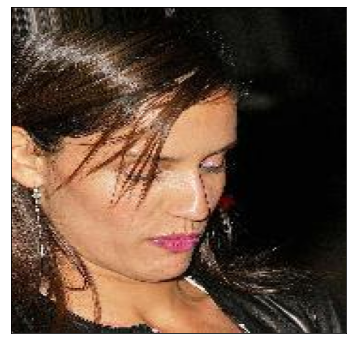

In [14]:
photo_sample = cv2.imread(photo_path + '000004.jpg')
photo_sample= cv2.cvtColor(photo_sample, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
fig = plt.imshow(photo_sample, aspect="auto")
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [15]:
#Wymiary zdjęcia
photo_sample.shape

(218, 178, 3)

##Podział zdjęć na podzbiory

Do podziału na następujące podzbiory będziemy musieli użyć przygotowachych list, dzięki którym zbiór zdjęć automatycznie podzieli się wg schematu:
- train
  - female
  - male
- valid
  - female
  - male
- test
  - female
  - male

In [16]:
#Wybór z tabeli attr kolumny "Male" i połączenie ją z kolumną "partition" ze zbioru partition
sampling_df = attr[['Male']].join(partition)
sampling_df.head()

,Male,partition
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [17]:
#Podział listy na zbiory train, valid, test

y_sampling_0 = sampling_df.loc[sampling_df['partition']== 0,:]
y_sampling_1 = sampling_df.loc[sampling_df['partition']== 1,:]
y_sampling_2 = sampling_df.loc[sampling_df['partition']== 2,:]

y_train = y_sampling_0.drop('partition', axis=1)
y_valid = y_sampling_1.drop('partition', axis=1)
y_test = y_sampling_2.drop('partition', axis=1)

In [18]:
#Podział powyższych zbiorów na podzbiory (kobiety i mężczyźni)
list_train_famale =  y_sampling_0.loc[y_sampling_0['Male']== 0,:]
list_train_male =  y_sampling_0.loc[y_sampling_0['Male']== 1,:]
list_valid_famale =  y_sampling_1.loc[y_sampling_1['Male']== 0,:]
list_valid_male =  y_sampling_1.loc[y_sampling_1['Male']== 1,:]
list_test_famale =  y_sampling_2.loc[y_sampling_2['Male']== 0,:]
list_test_male =  y_sampling_2.loc[y_sampling_2['Male']== 1,:]

In [22]:
#Utworzenie folderów colabie
!mkdir /content/Zbiory
!mkdir /content/Zbiory/train
!mkdir /content/Zbiory/train/female

!mkdir /content/Zbiory/train/male

!mkdir /content/Zbiory/test
!mkdir /content/Zbiory/test/female
!mkdir /content/Zbiory/test/male

!mkdir /content/Zbiory/valid
!mkdir /content/Zbiory/valid/female
!mkdir /content/Zbiory/valid/male

In [23]:
#Rozrzucenie zdjęć do folderów:

for photo_name in list_train_famale.index:
  shutil.move("/content/img_align_celeba/img_align_celeba/"+photo_name, 
            '/content/Zbiory/train/female')
for photo_name in list_train_male.index:
  shutil.move("/content/img_align_celeba/img_align_celeba/"+photo_name, 
            '/content/Zbiory/train/male')
for photo_name in list_valid_male.index:
  shutil.move("/content/img_align_celeba/img_align_celeba/"+photo_name, 
            '/content/Zbiory/valid/male')
for photo_name in list_valid_famale.index:
  shutil.move("/content/img_align_celeba/img_align_celeba/"+photo_name, 
            '/content/Zbiory/valid/female')
for photo_name in list_test_famale.index:
  shutil.move("/content/img_align_celeba/img_align_celeba/"+photo_name, 
            '/content/Zbiory/test/female')
for photo_name in list_test_male.index:
  shutil.move("/content/img_align_celeba/img_align_celeba/"+photo_name, 
            '/content/Zbiory/test/male')

##Stworzenie zbiorów danych ze zdjęć

In [34]:
#Zdefiniowanie generatorów

data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)
data_gen_test = ImageDataGenerator(rescale=1/255.)

train_generator = data_gen_train.flow_from_directory('/content/Zbiory/train/', 
                                                     target_size=(224, 224), 
                                                     batch_size=64, 
                                                     class_mode="binary",
                                                     color_mode='rgb')

valid_generator = data_gen_valid.flow_from_directory('/content/Zbiory/valid/', 
                                                     target_size=(224, 224), 
                                                     batch_size=64, 
                                                     class_mode="binary",
                                                     color_mode='rgb')

test_generator = data_gen_test.flow_from_directory('/content/Zbiory/test/', 
                                                     target_size=(224, 224), 
                                                     batch_size=64, 
                                                     class_mode="binary",
                                                     color_mode='rgb')

Found 162770 images belonging to 2 classes.
Found 19867 images belonging to 2 classes.
Found 19962 images belonging to 2 classes.


In [26]:
#Ile zdjęć jest w każdym zbiorze?
train_size = 162770
valid_size = 19867
test_size = 19962

#Modele

In [103]:
#Podstawienie liczby epok dla wszystkich modeli
numbers_of_epoch = 30

##Model 1

In [104]:
#optymalizator przyjęty w poniższym modelach
opt = tensorflow.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

#parametry przyjmowane przy uczeniu modelu (w celu przyspieszenia uczenia)
batch_size = 512
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

In [105]:
#Model pierwszy - jedna warstwa, 32 neurony

model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_initializer='he_uniform', padding='same'))
model1.add(MaxPool2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 401408)            0         
                                                                 
 dense_10 (Dense)            (None, 128)               51380352  
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 51,381,377
Trainable params: 51,381,377
Non-trainable params: 0
__________________________________________

In [106]:
model1.compile(optimizer=opt, loss="binary_crossentropy", metrics=['accuracy'])
history1= model1.fit(train_generator,epochs=numbers_of_epoch, validation_data=valid_generator, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/30
317/317 [==============================] - 45s 141ms/step - loss: 0.5006 - accuracy: 0.7524 - val_loss: 0.3357 - val_accuracy: 0.8651
Epoch 2/30
317/317 [==============================] - 45s 142ms/step - loss: 0.3576 - accuracy: 0.8469 - val_loss: 0.2580 - val_accuracy: 0.9001
Epoch 3/30
317/317 [==============================] - 45s 141ms/step - loss: 0.2815 - accuracy: 0.8843 - val_loss: 0.2090 - val_accuracy: 0.9252
Epoch 4/30
317/317 [==============================] - 44s 139ms/step - loss: 0.2441 - accuracy: 0.9014 - val_loss: 0.1775 - val_accuracy: 0.9371
Epoch 5/30
317/317 [==============================] - 44s 137ms/step - loss: 0.1987 - accuracy: 0.9207 - val_loss: 0.1546 - val_accuracy: 0.9441
Epoch 6/30
317/317 [==============================] - 44s 138ms/step - loss: 0.1913 - accuracy: 0.9223 - val_loss: 0.1513 - val_accuracy: 0.9396
Epoch 7/30
317/317 [==============================] - 43s 135ms/step - loss: 0.1646 - accuracy: 0.9361 - val_loss: 0.1203 - val_ac

312/312 [==============================] - 34s 109ms/step - loss: 0.1088 - accuracy: 0.9575


,loss,accuracy,val_loss,val_accuracy,epoch
0,0.500605,0.752366,0.335684,0.865132,1
1,0.357638,0.846905,0.258002,0.900082,2
2,0.281467,0.884349,0.209046,0.925164,3
3,0.244129,0.901420,0.177486,0.937089,4
4,0.198651,0.920692,0.154560,0.944079,5
5,0.191282,0.922269,0.151269,0.939556,6
6,0.164590,0.936071,0.120336,0.958470,7
7,0.156206,0.937746,0.120515,0.953947,8
8,0.155067,0.940802,0.134252,0.944490,9
9,0.140179,0.944894,0.116784,0.956003,10


Test Accuracy: 0.9575192928314209


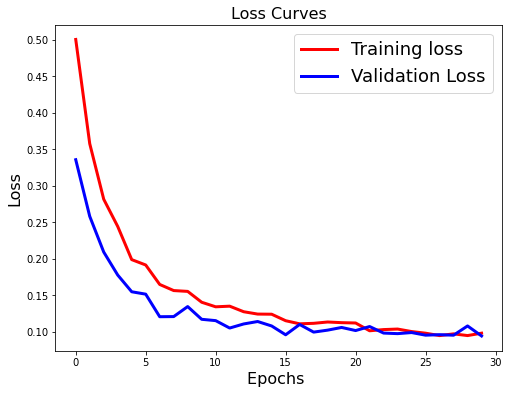

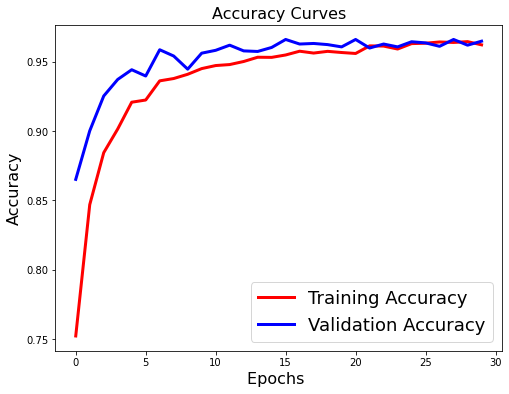

In [107]:
#Dokładność modelu na zbiorze testowym
test_accuracy_model1 = model1.evaluate(test_generator)[1]
describe_model(history1,model1, test_accuracy_model1)

Dokładność w modelu 1 wyniosła: 0.9575

##Model 2

In [108]:
#Model2 - sieć konwolucyjna z zastosowaniem early stoppingu

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3),kernel_initializer='he_uniform', padding='same'))
model2.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model2.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model2.add(MaxPool2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(1, activation='sigmoid'))
opt = tensorflow.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model2.compile(optimizer=opt, loss="binary_crossentropy", metrics=['accuracy'])
model2.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                 

Epoch 1/30
317/317 [==============================] - 74s 230ms/step - loss: 0.4760 - accuracy: 0.7743 - val_loss: 0.2683 - val_accuracy: 0.8976
Epoch 2/30
317/317 [==============================] - 72s 226ms/step - loss: 0.2227 - accuracy: 0.9100 - val_loss: 0.1822 - val_accuracy: 0.9342
Epoch 3/30
317/317 [==============================] - 71s 225ms/step - loss: 0.1683 - accuracy: 0.9341 - val_loss: 0.1629 - val_accuracy: 0.9354
Epoch 4/30
317/317 [==============================] - 72s 226ms/step - loss: 0.1456 - accuracy: 0.9443 - val_loss: 0.1256 - val_accuracy: 0.9539
Epoch 5/30
317/317 [==============================] - 72s 226ms/step - loss: 0.1304 - accuracy: 0.9516 - val_loss: 0.0965 - val_accuracy: 0.9671
Epoch 6/30
317/317 [==============================] - 72s 226ms/step - loss: 0.1273 - accuracy: 0.9501 - val_loss: 0.1160 - val_accuracy: 0.9564
Epoch 7/30
317/317 [==============================] - 72s 227ms/step - loss: 0.1170 - accuracy: 0.9556 - val_loss: 0.0970 - val_ac

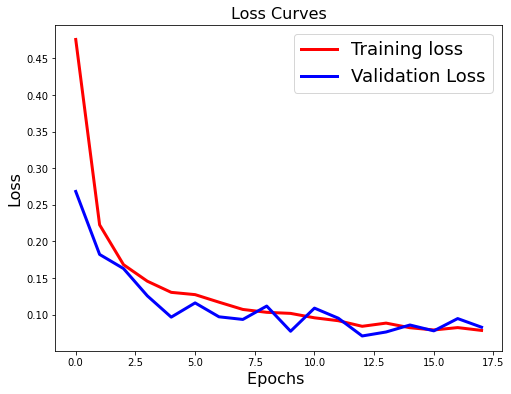

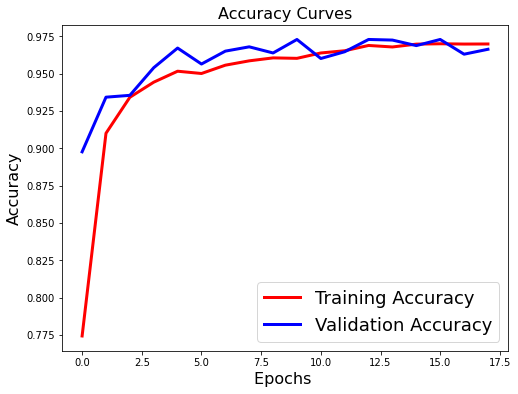

In [109]:
model2.compile(optimizer=opt, loss="binary_crossentropy", metrics=['accuracy'])
#jeśli przez 5 epok strata na zbiorze walidacyjnym nie zmienia się to epoka się kończy
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history2= model2.fit(train_generator,
                     epochs=numbers_of_epoch, 
                     validation_data=valid_generator, 
                     steps_per_epoch=steps_per_epoch, 
                     validation_steps=validation_steps, 
                     callbacks=[early_stop])

plot_history(history2)

312/312 [==============================] - 36s 115ms/step - loss: 0.0962 - accuracy: 0.9640


,loss,accuracy,val_loss,val_accuracy,epoch
0,0.475983,0.774281,0.268272,0.897615,1
1,0.222651,0.910045,0.182199,0.934211,2
2,0.168257,0.934148,0.162925,0.935444,3
3,0.145606,0.944253,0.125577,0.953947,4
4,0.130385,0.951597,0.096525,0.967105,5
5,0.127278,0.950069,0.115965,0.956414,6
6,0.116971,0.955639,0.096963,0.965049,7
7,0.107030,0.958547,0.093370,0.967928,8
8,0.103093,0.960528,0.111651,0.963816,9
9,0.101635,0.960223,0.077238,0.972862,10


Test Accuracy: 0.9640316367149353


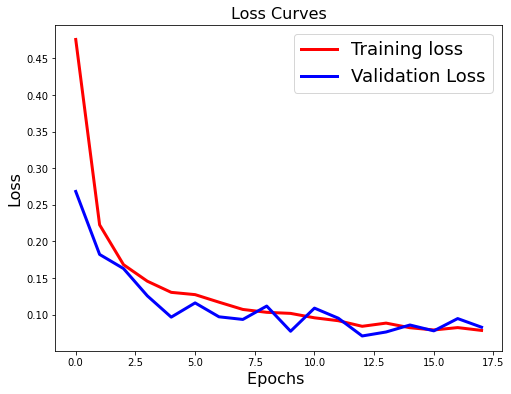

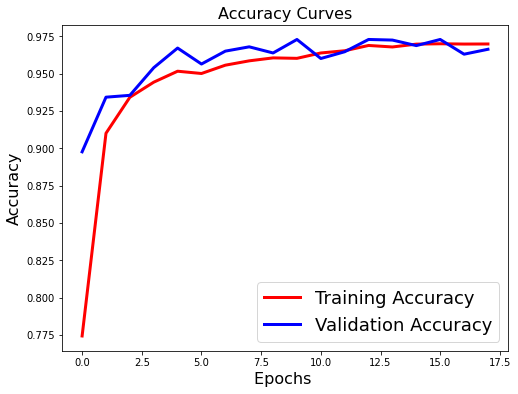

In [110]:
#Dokładność modelu na zbiorze testowym
test_accuracy_model2 = model2.evaluate(test_generator)[1]
describe_model(history2,model2, test_accuracy_model2)

Dokładność w modelu 1 wyniosła: 0.9640

##Model 3

In [111]:
#może resnet50??? https://towardsdatascience.com/how-to-predict-an-image-with-keras-ca97d9cd4817

#Model 3 - wykorzystanie MobileNet

model3 = MobileNet(input_shape=(224, 224, 3), pooling='max', weights=None, classes=1, classifier_activation='sigmoid')

model3.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

Epoch 1/30
317/317 [==============================] - 120s 371ms/step - loss: 0.5747 - accuracy: 0.6921 - val_loss: 0.8646 - val_accuracy: 0.5761
Epoch 2/30
317/317 [==============================] - 118s 370ms/step - loss: 0.4370 - accuracy: 0.7931 - val_loss: 2.1365 - val_accuracy: 0.5625
Epoch 3/30
317/317 [==============================] - 117s 369ms/step - loss: 0.3354 - accuracy: 0.8508 - val_loss: 0.3447 - val_accuracy: 0.8475
Epoch 4/30
317/317 [==============================] - 117s 369ms/step - loss: 0.2692 - accuracy: 0.8795 - val_loss: 0.4099 - val_accuracy: 0.8088
Epoch 5/30
317/317 [==============================] - 118s 373ms/step - loss: 0.2364 - accuracy: 0.8970 - val_loss: 0.6094 - val_accuracy: 0.7660
Epoch 6/30
317/317 [==============================] - 118s 373ms/step - loss: 0.2199 - accuracy: 0.9060 - val_loss: 0.2524 - val_accuracy: 0.8919
Epoch 7/30
317/317 [==============================] - 117s 368ms/step - loss: 0.2059 - accuracy: 0.9127 - val_loss: 0.2608 -

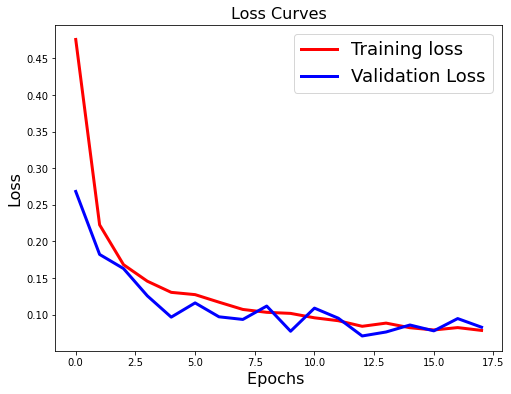

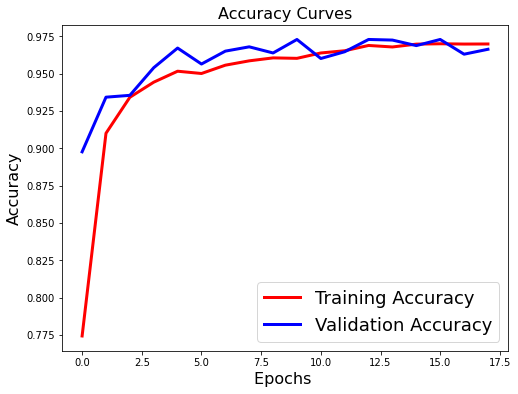

In [112]:
model3.compile(optimizer=opt, loss="binary_crossentropy", metrics=['accuracy'])
history3= model3.fit(train_generator,epochs=numbers_of_epoch, validation_data=valid_generator, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_history(history2)

312/312 [==============================] - 36s 115ms/step - loss: 0.1188 - accuracy: 0.9519


,loss,accuracy,val_loss,val_accuracy,epoch
0,0.574727,0.692133,0.864631,0.576069,1
1,0.436977,0.793080,2.136501,0.562500,2
2,0.335378,0.850805,0.344700,0.847451,3
3,0.269219,0.879535,0.409882,0.808799,4
4,0.236394,0.897033,0.609425,0.766036,5
5,0.219889,0.905954,0.252407,0.891859,6
6,0.205915,0.912658,0.260799,0.900082,7
7,0.188591,0.920544,0.157893,0.937089,8
8,0.178715,0.926410,0.178850,0.928454,9
9,0.171224,0.927050,0.198553,0.916941,10


Test Accuracy: 0.9518585205078125


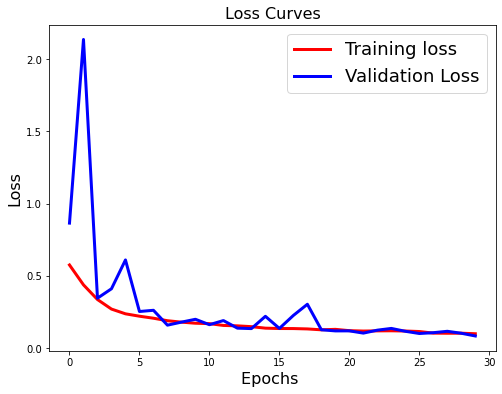

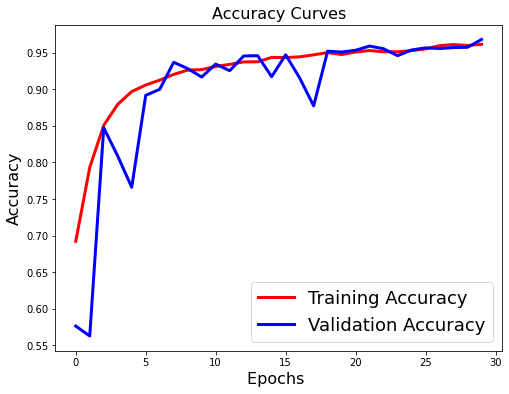

In [113]:
#Dokładność modelu na zbiorze testowym

test_accuracy_model3 = model3.evaluate(test_generator)[1]
describe_model(history3,model3, test_accuracy_model3)

Dokładność w modelu 1 wyniosła: 0.9518

#Sprawdzenie przewidywań najlepszego modelu na przykładzie

In [5]:
print(f"Dokładność na zbiorze testowym w MODELU_1: {round(test_accuracy_model1,4)}")
print(f"Dokładność na zbiorze testowym w MODELU_2: {round(test_accuracy_model2,4)}")
print(f"Dokładność na zbiorze testowym w MODELU_3: {round(test_accuracy_model3,4)}")

Dokładność na zbiorze testowym w MODELU_1: 0.9575
Dokładność na zbiorze testowym w MODELU_2: 0.964
Dokładność na zbiorze testowym w MODELU_3: 0.9518


In [65]:
#Do utworzonego folderu należy wrzucić przykładowe zdjęcie
!mkdir /content/Zbiory/sample

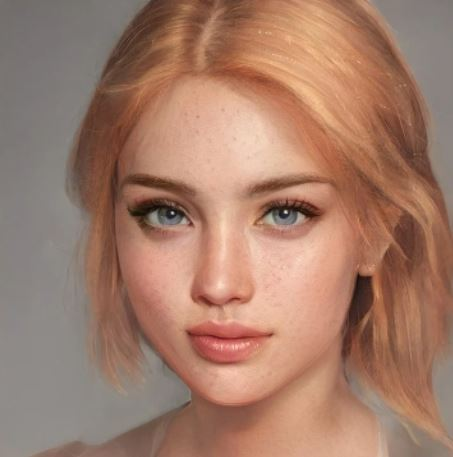

In [67]:
#Przykładowe zdjęcie

photo_path = '/content/Zbiory/sample/'
photo_name = 'sample.png'

photo_my_sample = cv2.imread(photo_path + photo_name)
cv2_imshow(photo_my_sample)

In [70]:
#Sprawdzenie, jak model określi płeć osoby ze zdjęcia

classify_gender(photo_path + photo_name, model2)

Na zdjęciu jest kobieta
